# IMPORT LIBRARIES

In [1]:
import requests
import zipfile
import os
import tensorflow as tf
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import os
import math
import dill

from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from tqdm import tqdm
from PIL import Image

# SETUP CONSTANTS
* In this section, we will define some constants that are important for data processing and model training.
* These constants will help us set the dataset folder path, the extension pattern of the image files to be collected, and which folders to access.
* Later, these constants will be used in various parts of the code.

## function

In [2]:
def download_and_extract_zip(url, save_dir, extract_dir, filename="dataset.zip", chunk_size=1024, is_file_removed=True):
    """"
    Downloads a zip file from a URL and extracts it to the specified directory only if there is no extract result yet.
    Args:
        url(str): URL of the zip file to download.
        save_dir (str): The directory where to save the zip file.
        extract_dir (str): The destination directory to extract the zip file.
        filename (str, optional): The name of the saved zip file. Default “dataset.zip”.
        chunk_size (int, optional): The chunk size for the download. Default 1024 (1 KB).
        is_file_removed (bool, optional): Delete the zip file after extraction. Default True.
    Raises:
        Exception: If there is an error while downloading or extracting the file.
    """

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(extract_dir, exist_ok=True)

    zipfile_path = os.path.join(save_dir, filename)

    if os.listdir(extract_dir):  
        print("File sudah diekstrak sebelumnya. Tidak ada tindakan lebih lanjut.")
        return  

    try:
        if not os.path.exists(zipfile_path):
            response = requests.get(url, stream=True, timeout=10)
            response.raise_for_status() 

            total_size = int(response.headers.get('content-length', 0))
            with open(zipfile_path, "wb") as file, tqdm(
                    desc=f"Downloading {filename}",
                    total=total_size,
                    unit='B', unit_scale=True, unit_divisor=1024,
            ) as bar:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    file.write(chunk)
                    bar.update(len(chunk))

            print(f"\nFile downloaded to {zipfile_path}")
        else:
            print(f"{filename} sudah ada di {zipfile_path}.")

        with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
            print(f"Files extracted to {extract_dir}")

    except requests.exceptions.RequestException as e:
        raise Exception(f"Error downloading the file: {e}")

    except zipfile.BadZipFile:
        raise Exception("Error: The downloaded file is not a valid zip file.")

    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")

    finally:
        if os.path.exists(zipfile_path) and is_file_removed:
            os.remove(zipfile_path)
            print("Downloaded zip file removed.")

In [3]:
def custom_title_print(title, n_strip=80):
    """
    Prints a customized title with border lines above and below the title.
    Args:
        title (str): The title to display.
        n_strip (int): The number of '=' characters to create the border. Default is 80.
    Returns:
        None
    """

    print('=' * n_strip)
    print(f' {title.upper()} '.center(n_strip, '='))
    print('=' * n_strip)

In [4]:
def collect_images_with_regex_and_count(path, folders, extensions_pattern):
    """
    Collects image paths from multiple folders in the main path by filtering images
    by extension using regex. This function returns a dictionary with a key of
    folder name and the value is a list of image file paths.
    Args:
        path (str): The main path of the folder containing the image data sub-folders.
        folders (list): A list of folder names to scan for images.
        extensions_pattern (str): A regex pattern to match image file extensions (example: r'\.(jpg|png|jpeg)$').
    Returns:
        dict: A dictionary with the key being the folder name and the value being a list of image file paths that match the pattern.
    """

    try:
        image_paths = {folder: [] for folder in folders} 
        pattern = re.compile(extensions_pattern, re.IGNORECASE)

        for folder in folders:
            folder_path = Path(path) / folder

            for file_path in tqdm(folder_path.rglob("*"), desc=f"Collecting from {folder}", unit=" paths"):
                if pattern.search(file_path.suffix):
                    image_paths[folder].append(file_path)

        return image_paths 

    except Exception as e:
        print(f"No classes are retrieved from directory validation")
        return {}

In [5]:
def get_random_images(image_paths, num_samples, seed=42):
    """
    Retrieve a random number of images from the image path list.
    Args:
        image_paths (list): A list of image paths.
        num_samples (int): The number of images to retrieve. If None, all images will be selected.
        seed (int): Seed to control the random retrieval results so that the results can be reproduced. Default is 42.
    Returns:
        list: A list of randomly selected image paths.
    """
    
    random.seed(seed)
    return random.sample(image_paths, min(len(image_paths) if num_samples is None else num_samples, len(image_paths)))


In [6]:
def collect_and_combine_images(classes, train_path=None, valid_path=None, pattern_regex=r"\.(jpe?g)$", num_images_per_class=None, seed=42):
    """
    Collects and merges images from the training and validation folders, and retrieves a random number of images from each class.
    Args:
        classes (list): List of classes (folder names) to process.
        train_path (str): The main path of the training folder that contains image data sub-folders.
        valid_path (str): The main path of the validation folder that contains the image data sub-folders.
        pattern_regex (str): The regex pattern for matching image file extensions (e.g. r'\.(jpg|png|jpeg)$').
        num_images_per_class (dict): Dictionary containing the number of images to fetch for each class. If None, all images will be retrieved.
        seed (int): Seed for random image retrieval. Default is 42.
    Returns:
        list: A combined list of image paths from the training and validation folders that were randomly retrieved.
    """

    try:
        def process_class(cls):
            all_train_images = train_images_paths.get(cls, [])
            all_valid_images = valid_images_paths.get(cls, [])
            all_combined_images = all_train_images + all_valid_images

            return get_random_images(
                image_paths=all_combined_images,
                num_samples=None if num_images_per_class is None else num_images_per_class.get(cls, len(all_combined_images)),
                seed=seed
            )

        custom_title_print(f"COLLECT {classes} FROM TRAINING DATA")
        train_images_paths = collect_images_with_regex_and_count(train_path, classes, pattern_regex)
        print()

        custom_title_print(f"COLLECT {classes} FROM VALIDATION DATA")
        valid_images_paths = collect_images_with_regex_and_count(valid_path, classes, pattern_regex)
        print()
        print()

        custom_title_print(f"COMBINING {classes} FROM TRAINING AND VALIDATION DATA")

        random_images = {}

        with ThreadPoolExecutor() as executor:
            results = executor.map(process_class, classes)

        for cls, images in zip(classes, results):
            random_images[cls] = images
            print(f"Total {cls} taken: {len(random_images[cls])}")

        all_images_paths = sum(random_images.values(), [])
        all_images_paths = [str(path) for path in all_images_paths]
        print(f"Total images taken: {len(all_images_paths)}".upper())

        return all_images_paths

    except Exception as e:
        print(f"Error: {e}")
        return []

In [7]:
def save_object(file_path, obj):
    """
    Saves the object into a file using serialization with dill.
    Args:
        file_path (str): The path of the file where the object will be saved.
        obj (object): The object to save, which can be a list, dictionary, or other Python object.
    Returns:
        None
    """

    try:
        if os.path.exists(file_path):
            print(f"File '{file_path}' already exists. Skipping saving.")
            return 

        dir_path = os.path.dirname(file_path) 
        os.makedirs(dir_path, exist_ok=True) 

        with open(file_path, 'wb') as file_obj: 
            dill.dump(obj, file_obj)
        print(f"Object saved to {file_path}")

    except Exception as e:
        print(f"Error saving object: {e}")

## main program

In [8]:
# ==========================================================================================
# ==================================== PARENT PATH CONSTANT ================================
# ==========================================================================================
PARENT_DATASET_PATH = ".."
DATA_DOWNLOAD_URL = "https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip"
ARTIFACTS_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts")
DATA_INGESTION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_ingestion")
DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_transformation")
OBJECT_PATH = os.path.join(ARTIFACTS_PATH, "objects")
REPORT_PATH = os.path.join(ARTIFACTS_PATH, "reports")

# ==========================================================================================
# ==================================== DATA PATH CONSTANT ==================================
# ==========================================================================================
TRAIN_PATH = os.path.join(DATA_INGESTION_ARTIFACTS_DIR_PATH, "dataset-resized")
TRAIN_TFRECOARD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "train_trashnet.tfrecord")
VALID_TFRECORD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "valid_trashnet.tfrecord")



# ==========================================================================================
# =============================== OBJECT PATH CONSTANT =====================================
# ==========================================================================================
LABEL_LIST_PATH = os.path.join(OBJECT_PATH, "label_list.pkl")
CLASS_WEIGHTS_PATH = os.path.join(OBJECT_PATH, "class_weights.pkl")


# ==========================================================================================
# ======================================== CONSTANT ========================================
# ==========================================================================================
PATTERN_IMAGE_EXT_REGEX = r"\.(jpe?g|png)$"
LABEL_LIST = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
SPLIT_RATIO = (0.9, 0.1)
IMAGE_SIZE = (224, 224)

### DATA INGESTION

In [9]:
download_and_extract_zip(
    url=DATA_DOWNLOAD_URL, 
    save_dir=DATA_INGESTION_ARTIFACTS_DIR_PATH, 
    extract_dir=DATA_INGESTION_ARTIFACTS_DIR_PATH,
    is_file_removed=False
)


File downloaded to ..\artifacts\data_ingestion\dataset.zip
Files extracted to ..\artifacts\data_ingestion


#### Saving and Combining Images from Training and Validation Folders

* In this section, we use the `collect_and_combine_images` function to collect and combine images, from the training and validation folders based on the classes in `NUM_IMAGES_PER_CLASS`. This function will randomly select images according to the predefined number for each class.
* After the image collection process is complete, all image paths are stored in the `ALL_IMAGES_PATHS` variable for use in the next process.

In [10]:
ALL_IMAGES_PATHS = collect_and_combine_images(
    classes = LABEL_LIST,
    train_path  = TRAIN_PATH,
    pattern_regex = PATTERN_IMAGE_EXT_REGEX,
)

 COLLECT ['CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC', 'TRASH'] FROM TRAINING DATA 



 COLLECT ['CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC', 'TRASH'] FROM VALIDATION DATA 
No classes are retrieved from directory validation


 COMBINING ['CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC', 'TRASH'] FROM TRAINING AND VALIDATION DATA 
Total cardboard taken: 403
Total glass taken: 501
Total metal taken: 410
Total paper taken: 594
Total plastic taken: 482
Total trash taken: 137
TOTAL IMAGES TAKEN: 2527


#### Saving Label Encoding
* In addition, we also use the `save_object` function to save the object into a file.
* In this example, we save the list of classes used for encoding labels in the path defined earlier, `LABEL_LIST_PATH`.
* This object is saved in serialized format using `dill` so that it can be reloaded at a later time.

In [11]:
save_object(
    file_path=LABEL_LIST_PATH,
    obj=LABEL_LIST
)

Object saved to ..\artifacts\objects\label_list.pkl


# PREPARING DATA WORKFLOW

## Step 1. Data Exploration

### function

In [12]:
class FilePathInfo:
    """
    The FilePathInfo class is used to display detailed information about file paths on a dataset, including
    file name, extension, file size, and label (if any). This class also supports the use of different
    size units such as 'bytes', 'kb', 'mb', and 'gb'.
    Args:
        unit_file_size (str, optional): The unit to display the file size ('bytes', 'kb', 'mb', 'gb'). Default is 'bytes'.
    """

    def __init__(self, unit_file_size='bytes'):
        """
        Initialize the FilePathInfo class with the given file size unit.
        Args:
            unit_file_size (str, optional): The unit to display the file size ('bytes', 'kb', 'mb', 'gb'). Default is 'bytes'.
        """

        self.unit_file_size = unit_file_size.lower()
        self.units = ['bytes', 'kb', 'mb', 'gb']
        if self.unit_file_size not in self.units:
            raise ValueError(f"Invalid unit. Choose from {self.units}.")

    def show_train_files_path_info(self, files_path_data, is_labeled=True, is_random=False):
        """
        Display detailed information about file paths in the training dataset.
        Args:
            files_path_data(tf.data.Dataset): The dataset containing the file paths.
            is_labeled (bool, optional): Indicates whether the dataset has a label. Default is True.
            is_random (bool, optional): Indicates whether the dataset needs to be randomized before displaying. Default is False.
        Returns:
            int: The label index on the file path, if the dataset has a label.
        """

        files_path_data_plot = self._get_files_path_data_plot(files_path_data, is_random)
        label_index = self._display_path_info(files_path_data_plot, is_labeled)
        return label_index

    def show_test_files_path_info(self, files_path_data, is_labeled=False, is_random=False):
        """
        Displays detailed information about the file path in the dataset.
        Args:
            files_path_data(tf.data.Dataset): The dataset containing the file path.
            is_random (bool, optional): Indicates whether the dataset needs to be randomized before display. Default is False.
        """

        files_path_data_plot = self._get_files_path_data_plot(files_path_data, is_random)
        self._display_path_info(files_path_data_plot, is_labeled)

    def _get_files_path_data_plot(self, files_path_data, is_random):
        """
        Retrieves a subset of the file path dataset, with randomization options.
        Args:
            files_path_data(tf.data.Dataset): The dataset containing the file paths.
            is_random (bool): Whether the dataset needs to be randomized.
        Returns:
            tf.data.Dataset: A subset of the selected dataset.
        """

        if is_random:
            return files_path_data.shuffle(buffer_size=files_path_data.cardinality().numpy()).take(1)
        else:
            return files_path_data.take(1)

    def _display_path_info(self, files_path_data_plot, is_labeled):
        """
        Displays the full information of the selected file path, including file name, extension, size, and label if any.
        Args:
            files_path_data_plot(tf.data.Dataset): A subset of the dataset to be displayed.
            is_labeled (bool): Indicates whether the dataset has a label.
        Returns:
            int: The label index on the file path if the dataset is labeled.
        """

        for file_path in files_path_data_plot:
            custom_title_print(' PATH INFO ')
            print(f'File Path: {file_path.numpy().decode("utf-8")}')
            print()

            split_file_path = self._split_file_path(file_path)
            self._display_split_file_path(split_file_path)

            if is_labeled:
                kind_data = split_file_path[-3].numpy().decode('utf-8')
                index_label = self._display_kind_data_info(split_file_path, kind_data)
                self._display_file_info(split_file_path, file_path)
                return index_label
            else:
                self._display_file_info(split_file_path, file_path)

    def _split_file_path(self, file_path):
        """
        Breaks the file path into parts using the file system separator.
        Args:
            file_path(tf.Tensor): File path.
        Returns:
            tf.Tensor: The split file path.
        """

        return tf.strings.split(file_path, os.path.sep)

    def _display_split_file_path(self, split_file_path):
        """
        Displays the path of the split file and the index of each section.
        Args:
            split_file_path(tf.Tensor): The path of the split file.
        """

        custom_title_print(' SPLIT FILE PATH ')
        print(f'Split File Path: {split_file_path}')
        print()

        custom_title_print(' INDEXED PATH ')
        result = {value: f'Index -> {index}' for index, value in enumerate(split_file_path.numpy())}
        for key, value in result.items():
            print(f'{value}: {key}')
        print()

    def _display_kind_data_info(self, split_file_path, kind_data):
        """
        Displays the index and label of the data based on its type.
        Args:
            split_file_path(tf.Tensor): The path of the split file.
            kind_data (str): The type of data in the file path.
        Returns:
            int: The index of the label in the file path.
        """

        custom_title_print(f' KIND DATA INDEX {kind_data} ')
        index = tf.where(tf.equal(split_file_path, kind_data))[0][0]
        print(f'Index of "{kind_data}": {index}')
        print()

        index_label = index + 1
        custom_title_print(' INDEX LABEL ')
        print(f'Index Label: {index_label}')
        print()

        custom_title_print(' LABEL ')
        print(f'Label: {split_file_path[index_label]}')
        print()

        return index_label.numpy()

    def _display_file_info(self, split_file_path, file_path):
        """
        Displays detailed information about the file such as name, extension, and file size.
        Args:
            split_file_path(tf.Tensor): The path of the split file.
            file_path (tf.Tensor): The path of the file.
        """

        file_name = split_file_path[-1].numpy().decode('utf-8')
        custom_title_print(' FILE NAME ')
        print(f'File Name: {file_name}')
        print()

        file_extension = os.path.splitext(file_name)[1]
        custom_title_print(' FILE EXTENSION ')
        print(f'File Extension: {file_extension}')
        print()

        image_size = Image.open(file_path.numpy().decode('utf-8')).size
        custom_title_print(' IMAGE SIZE (PX)')
        print(f'Image Size: \n width={image_size[0]} \n height={image_size[1]}')
        print()

        file_size = os.path.getsize(file_path.numpy().decode('utf-8'))
        file_size = self._format_file_size(file_size)
        custom_title_print(' FILE SIZE ')
        print(f'File Size: {file_size} {self.unit_file_size}')
        print()


    def _format_file_size(self, size):
        """
        Format the file size according to the selected unit.
        Args:
            size (int): File size in bytes.
        Returns:
            str: The size of the formatted file.
        """
        
        if self.unit_file_size == 'kb':
            size /= 1024
        elif self.unit_file_size == 'mb':
            size /= 1024 ** 2
        elif self.unit_file_size == 'gb':
            size /= 1024 ** 3

        return f'{size:.4f}' if self.unit_file_size != 'bytes' else size

In [13]:
def images_to_sprite(image_paths, sprite_size=(256, 256), background_color=(255, 255, 255)):
    """
    Creates a sprite image from a set of images by arranging them in a grid.
    Args:
        image_paths (list): List of image paths to be merged.
        sprite_size (tuple): The final size (width, height) of each image in the sprite.
        background_color (tuple): The background color (R, G, B) for the empty area in the grid.
    Returns:
        PIL.Image: The merged sprite image.
    """

    num_images = len(image_paths)
    grid_size = math.ceil(math.sqrt(num_images))

    sprite_width = grid_size * sprite_size[0]
    sprite_height = grid_size * sprite_size[1]
    sprite_image = Image.new("RGB", (sprite_width, sprite_height), background_color)

    for idx, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        img = img.resize(sprite_size, Image.LANCZOS)

        row = idx // grid_size
        col = idx % grid_size
        sprite_image.paste(img, (col * sprite_size[0], row * sprite_size[1]))

    return sprite_image


### main program

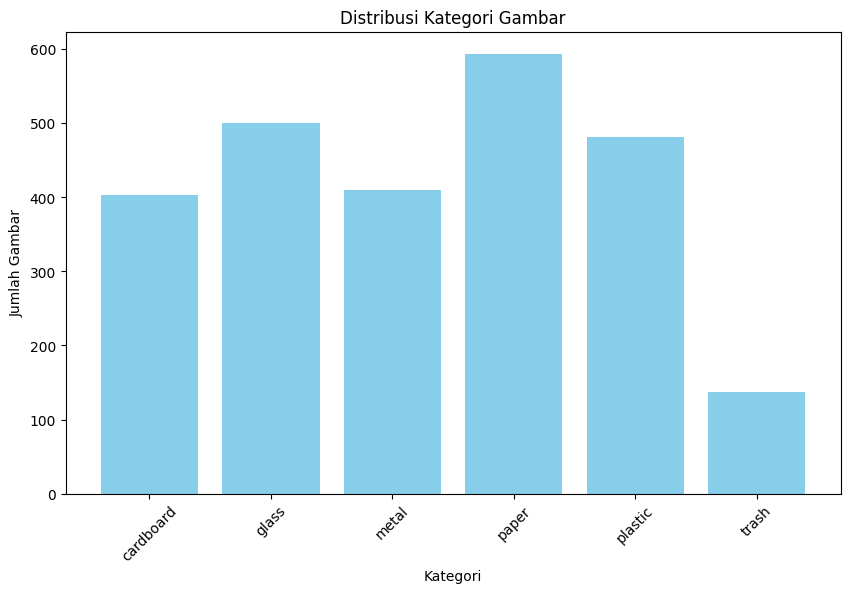

In [14]:
categories = [os.path.basename(os.path.dirname(path)) for path in ALL_IMAGES_PATHS]

category_counts = Counter(categories)

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.title('Distribusi Kategori Gambar')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()

From the graph, we can see some important things about the distribution of data in this **trashnet** dataset:
1. **Class Imbalance**  
   This dataset looks **imbalanced** because some classes have far more samples than others. For example:
   - **"Paper ”** has the highest number of samples, indicating that this class dominates the dataset.
   - **"Trash ”** is the minority class with the least number of samples, making it far below the other classes.
2. **Potential Model Bias**  
   This data imbalance can potentially cause bias in the model during training. If the model is trained on a dataset like this without any adjustments, it is more likely  to recognize the majority class** (such as “paper”) with higher accuracy. On the other hand, the model may have  a hard time recognizing classes with less data** (such as “trash”), and this could lead to poor performance on those classes.
3. **Need for Augmentation or Adjustment**  
   Given the difference in sample size between classes, we should consider **oversampling** or **weighted loss** techniques when training the model. For example:
   - **Weighted Loss Function**: Giving more weight to minority classes (e.g. “trash”) in the loss function can help the model not to “ignore” them during the training process.
4. **Evaluation with Appropriate Methods**  
   Due to unbalanced datasets, evaluation metrics such as **accuracy** may not adequately represent the overall performance of the model. For example, the model may achieve high accuracy only by recognizing the majority class well, but fail in the minority class. Therefore, it is recommended to use **precision, recall, and F1-score** per class to better clarify the performance of the model in each class.
5. **Impact on Real-World Applications**  
   If this dataset is used for real-world applications (e.g., an automated garbage classification system), this imbalance may reduce its effectiveness. For example, if the model frequently fails to recognize “trash,” it may cause trash that actually needs to be disposed of or treated in some way to be misclassified, preventing the system from working optimally.
   
**Conclusion:**\
Overall, **this graph shows that there are imbalances that need to be addressed** to ensure the model can properly recognize all classes, not just the majority. Implementation of imbalance handling techniques such as **augmentation of minority classes**, **weighted loss**, or **evaluation with appropriate metrics** is highly recommended to achieve fairer performance across classes.

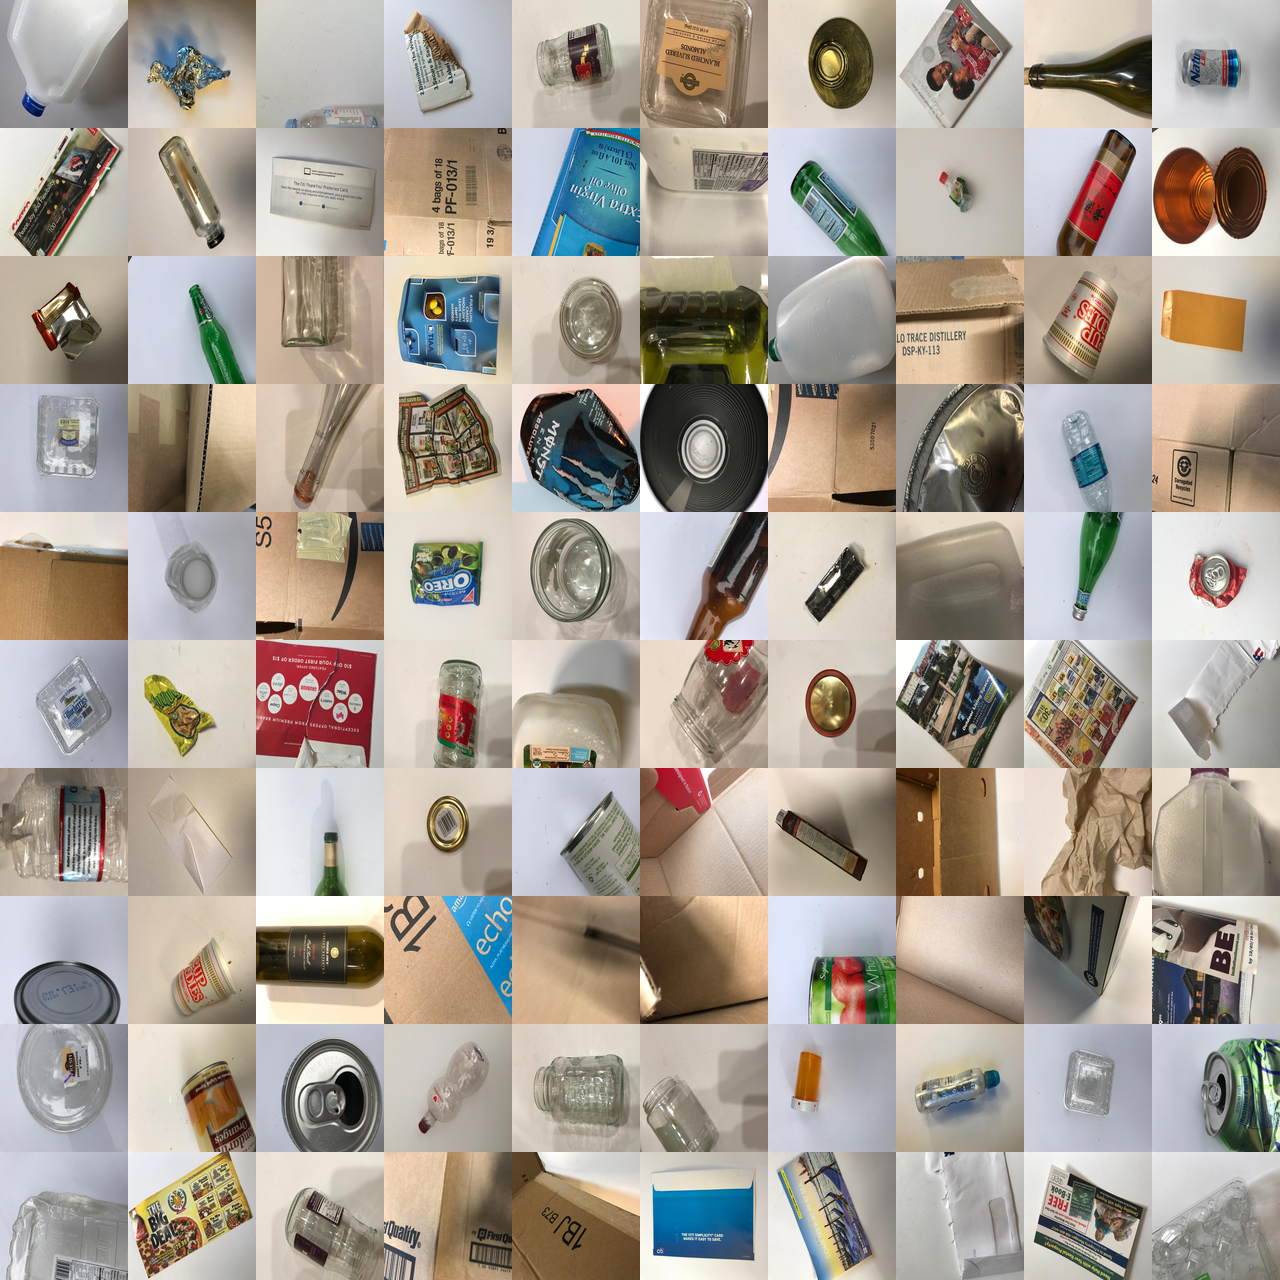

In [15]:
num_imgs = 100
random_images = random.sample(ALL_IMAGES_PATHS, num_imgs)
sprite_image = images_to_sprite(random_images, sprite_size=(128, 128))
sprite_image

#### Collecting File Paths and Displaying File Information
* In this section, we use `tf.data.Dataset.list_files` to create a dataset of the file paths we have collected in the `ALL_IMAGES_PATHS` variable. This dataset will contain the path of each image, and we can use it for further processing, such as loading images or displaying file information.

In [16]:
tf_paths = tf.data.Dataset.list_files(ALL_IMAGES_PATHS, shuffle=False)

In [17]:
for path in tf_paths.take(1):
  print(path)

tf.Tensor(b'..\\artifacts\\data_ingestion\\dataset-resized\\cardboard\\cardboard1.jpg', shape=(), dtype=string)


In [18]:
print(f'data: {tf_paths}')
print(f'number of data: {tf_paths.cardinality()}')

data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
number of data: 2527


After that, we create a `FilePathInfo` object with a file size unit of 'KB'. This object is used to display detailed information about the files in the path, such as file name, size, and extension.

In [19]:
file_info  = FilePathInfo(unit_file_size='KB')

The `show_train_files_path_info` function of the `FilePathInfo` class will be used to randomly display such information from the existing file path dataset. In addition, we also get the label index of the file that contains the label for the data class.

In [20]:
LABEL_INDEX = file_info.show_train_files_path_info(tf_paths, is_random=True)

=================================  PATH INFO  ==================================
File Path: ..\artifacts\data_ingestion\dataset-resized\plastic\plastic232.jpg

==============================  SPLIT FILE PATH  ===============================
Split File Path: [b'..' b'artifacts' b'data_ingestion' b'dataset-resized' b'plastic'
 b'plastic232.jpg']

================================  INDEXED PATH  ================================
Index -> 0: b'..'
Index -> 1: b'artifacts'
Index -> 2: b'data_ingestion'
Index -> 3: b'dataset-resized'
Index -> 4: b'plastic'
Index -> 5: b'plastic232.jpg'

======================  KIND DATA INDEX DATASET-RESIZED  =======================
Index of "dataset-resized": 3

================================  INDEX LABEL  =================================
Index Label: 4

===================================  LABEL  ====================================
Label: b'plastic'

=================================  FILE NAME  ==================================
File Name: plastic232.jp

## Step 2. Split Data

### function

In [27]:
class DatasetSplitter:
    """
    This class is used to split the dataset into three parts: training, validation, and testing.
    The division is done based on a configurable ratio, and the dataset can be randomized before division.
    """

    def __init__(self):
        """
        Initialize the `DatasetSplitter` class. No arguments are accepted during initialization.
        """
        pass

    def split_train_valid_test(self, dataset, split_ratio=None, shuffle=True, buffer_size=None, seed=42):
        """
        Splits the dataset into three parts: training, validation, and testing.
        Args:
            dataset(tf.data.Dataset): The dataset to be split.
            train_ratio (float, optional): The ratio of data for training. Default is 0.7.
            valid_ratio (float, optional): Data ratio for validation. Default is 0.2.
            shuffle (bool, optional): Whether the dataset needs to be shuffled before division. Default is True.
            buffer_size (int, optional): The buffer size for dataset shuffling. If None, buffer_size is taken from the dataset size.
            seed (int, optional): Seed for dataset randomization. Default is 42.
        Returns:
            tuple: A tuple containing the three split datasets: (train_dataset, val_dataset, test_dataset).
        """

        try:
            dataset_size = len(dataset) if buffer_size is None else buffer_size

            train_ratio = split_ratio[0]
            val_ratio = split_ratio[1]
            test_ratio = round(max(1.0 - (train_ratio + val_ratio), 0), 4)

            total_ratio = round(sum((train_ratio, val_ratio, test_ratio)), 2)
            if total_ratio != 1.0:
                raise ValueError("[ERROR] split_ratio must sum to 1.0.\n")

            train_size = int(round(dataset_size * train_ratio, 0))
            val_size = int(round(dataset_size * val_ratio, 0))
            test_size = int(round(dataset_size * test_ratio, 0))

            if shuffle:
                dataset = dataset.shuffle(buffer_size=dataset_size, seed=seed)

            train_dataset = dataset.take(train_size)
            val_test_dataset = dataset.skip(train_size)

            if test_size == 0:
                val_dataset = val_test_dataset.take(val_size)
                self._display_info(
                    dataset=dataset,
                    train_dataset=train_dataset,
                    valid_dataset=val_dataset,
                    dataset_size=dataset_size,
                    shuffle=shuffle,
                    test_size=test_size
                )

                return train_dataset, val_dataset
            else:
                val_dataset = val_test_dataset.take(val_size)
                test_dataset = val_test_dataset.skip(val_size)

                self._display_info(
                    dataset=dataset,
                    train_dataset=train_dataset,
                    valid_dataset=val_dataset,
                    test_dataset=test_dataset,
                    dataset_size=dataset_size,
                    shuffle=shuffle,
                    test_size=test_size
                )

                return train_dataset, val_dataset, test_dataset

        except Exception as e:
            print(f"Error: {e}")
            return None, None, None

    def _display_info(self, dataset=None, train_dataset=None, valid_dataset=None, test_dataset=None, dataset_size=None, shuffle=False, test_size=None):
        """
        Displays information about dataset splits such as size, ratio, and shuffle status.
        Args:
            dataset(tf.data.Dataset): The original dataset that has not been split.
            train_dataset (tf.data.Dataset): The training part of the dataset.
            valid_dataset (tf.data.Dataset): The validation part of the dataset.
            test_dataset (tf.data.Dataset): The testing dataset.
            dataset_size (int): The total size of the dataset.
            shuffle (bool): State whether the dataset is shuffled before dividing.
        """
        train_ratio = len(train_dataset) / dataset_size
        valid_ratio = len(valid_dataset) / dataset_size
        test_ratio = len(test_dataset) / dataset_size if test_size > 0 else 0

        print(f"Total number of data: {dataset_size}")
        print(f"Shuffle status: {shuffle}")

        custom_title_print(' Training Dataset ')
        print(f"Info data: {train_dataset}")
        print(f"Training Split: {round(train_ratio * 100, 2)}%")
        print(f"Number of data: {len(train_dataset)}")
        print()

        custom_title_print(' Validation Dataset ')
        print(f"Info data: {valid_dataset}")
        print(f"Validation Split: {round(valid_ratio * 100, 2)}%")
        print(f"Number of data: {len(valid_dataset)}")
        print()

        if test_size > 0:
            custom_title_print(' Test Dataset ')
            print(f"Info data: {test_dataset}")
            print(f"Test Split: {round(test_ratio * 100, 2)}%")
            print(f"Number of data: {len(test_dataset)}")


In [28]:
def extract_class_from_path_tf(path_tensor):
    """
    Extracts the class name from the file path stored in tensor form.
    Args:
        path_tensor(tf.Tensor): The tensor containing the file path.
    Returns:
        tf.Tensor: A tensor containing the name of the class extracted from the file path.
    """

    try:
        parts = tf.strings.split(path_tensor, os.path.sep)
        class_name = parts[-2]  # Nama kelas biasanya berada di posisi kedua dari belakang dalam jalur
        return class_name
    except Exception as e:
        print(f"Error: {e}")

In [29]:
def calculate_class_distribution_tf(dataset, class_labels):
    """
    Compute the class distribution and class weight using `compute_class_weight` from sklearn.
    Args:
        dataset (tf.data.Dataset): TensorFlow dataset containing images and labels.
        class_labels (list): An ordered list of class names (e.g. ['cardboard', 'glass', ...]).
    Returns:
        tuple: class_counts (Counter), class_weights (dict)
               class_weights in the form {label_index: weight}
    """

    try:
        class_names = dataset.map(lambda x: extract_class_from_path_tf(x))
        class_names_list = list(class_names.batch(1000).as_numpy_iterator())
        all_class_names = [name.decode('utf-8') for batch in class_names_list for name in batch]

        class_counts = Counter(all_class_names)

        class_indices = [class_labels.index(name) for name in all_class_names]

        class_weight_values = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(class_indices),
            y=class_indices
        )

        class_weights = {i: weight for i, weight in enumerate(class_weight_values)}

        return class_counts, class_weights

    except Exception as e:
        print(f"Error: {e}")

In [30]:
def print_class_distribution(distribution):
    """
    Prints the class distribution to the screen.
    Args:
        distribution(collections.Counter): A Counter object containing the class distribution.
    """
    
    for class_name, count in sorted(distribution.items()):
        print(f"{class_name}: {count}")

### main program

In [31]:
splitter = DatasetSplitter()

In [32]:
train_tf_paths, valid_tf_paths = splitter.split_train_valid_test(
    dataset=tf_paths,
    split_ratio=SPLIT_RATIO,
    shuffle=True,
    seed=12
)

Total number of data: 2527
Shuffle status: True
==============================  TRAINING DATASET  ==============================
Info data: <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Training Split: 89.99%
Number of data: 2274

=============================  VALIDATION DATASET  =============================
Info data: <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Validation Split: 10.01%
Number of data: 253



In [33]:
for train_path, valid_path in zip(train_tf_paths.take(1), valid_tf_paths.take(1)):
    print(train_path)
    print(valid_path)

tf.Tensor(b'..\\artifacts\\data_ingestion\\dataset-resized\\paper\\paper514.jpg', shape=(), dtype=string)
tf.Tensor(b'..\\artifacts\\data_ingestion\\dataset-resized\\glass\\glass44.jpg', shape=(), dtype=string)


In [34]:
train_class_distribution, class_weights = calculate_class_distribution_tf(train_tf_paths, LABEL_LIST)
valid_class_distribution, _ = calculate_class_distribution_tf(valid_tf_paths, LABEL_LIST)

In [35]:
class_weights

{0: 1.03551912568306,
 1: 0.8348017621145375,
 2: 1.0243243243243243,
 3: 0.7137476459510358,
 4: 0.871264367816092,
 5: 3.211864406779661}

#### Saving Encoding Labels

In [36]:
save_object(
    file_path=CLASS_WEIGHTS_PATH,
    obj=class_weights
)

Object saved to ..\artifacts\objects\class_weights.pkl


In [37]:
custom_title_print("Class distribution on Train set:")
print_class_distribution(train_class_distribution)
print()

custom_title_print("Class distribution in Validation set:")
print_class_distribution(valid_class_distribution)
print()

======================= CLASS DISTRIBUTION ON TRAIN SET: =======================
cardboard: 366
glass: 454
metal: 370
paper: 531
plastic: 435
trash: 118

==================== CLASS DISTRIBUTION IN VALIDATION SET: =====================
cardboard: 45
glass: 45
metal: 44
paper: 47
plastic: 53
trash: 19



## Step 3. Data Preprocessing

### function

In [38]:
def show_data_info(**datasets):
    """
    Display detailed information about the given dataset.
    Args:
        **datasets: One or more datasets for which you want to display information.
    """

    try:
        for dataset_name, dataset in datasets.items():
            custom_title_print(f"{dataset_name} info")
            print(f'info {dataset_name}: {dataset}')
            print(f'number of {dataset_name}: {len(dataset)}')
            print()
    except Exception as e:
        print(f'''
            explicitly input parameter names such as:
            show_data_info(train_dataset=train_ds, valid_dataset=valid_ds)
        ''')

In [39]:
def create_label_list_table(label_list, default_value=-1):
    """
    Creates a StaticHashTable for encoding labels based on the given list of labels.
    Args:
    - label_list (list): List of labels to encode.
    - default_value (int): The default value if the label is not found in the table.
    Returns:
    - label_table (tf.lookup.StaticHashTable): The hash table for encoding labels.
    """

    keys_tensor = tf.constant(label_list)

    values_tensor = tf.range(len(label_list))

    table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, values_tensor)

    label_table = tf.lookup.StaticHashTable(table_init, default_value=default_value)

    return label_table

In [40]:
def save_images_from_dataset(dataset, output_dir, label_mapping, max_images_per_class=None):
    """
    Save images from the TensorFlow dataset to a folder by label.
    Args:
    - Dataset: TensorFlow dataset containing (image, label) pairs.
    - output_dir: The main directory path to save the images.
    - label_mapping: List that maps label indexes to class names. Example: ['akiec', 'bcc'].
    - max_images_per_class: (Optional) Maximum number of images stored per class. If None, keep all images.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    saved_count_per_class = {class_name: 0 for class_name in label_mapping}

    total_images = {class_name: 0 for class_name in label_mapping}
    if max_images_per_class is None:
        for image, label in dataset:
            label_np = label.numpy()
            class_name = label_mapping[label_np]
            total_images[class_name] += 1

    for image, label in dataset:
        image_np = image.numpy()
        label_np = label.numpy()

        class_name = label_mapping[label_np]

        if max_images_per_class is not None and saved_count_per_class[class_name] >= max_images_per_class:
            if all(count >= max_images_per_class for count in saved_count_per_class.values()):
                print("Reached the maximum limit of images per class, stop saving.")
                break
            continue

        class_folder = os.path.join(output_dir, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)  

        saved_count_per_class[class_name] += 1
        file_name = f"{class_name}_{saved_count_per_class[class_name]}.jpg"
        file_path = os.path.join(class_folder, file_name)

        if not os.path.exists(file_path):
            image_np_uint8 = (image_np * 255).astype(np.uint8)

            image_pil = Image.fromarray(image_np_uint8)
            image_pil.save(file_path)

            total_images_class = max_images_per_class if max_images_per_class is not None else total_images[class_name]

            with tqdm(total=total_images_class, desc=f"Saving {class_name} images", unit="image", position=0, leave=False) as pbar:
                pbar.update(1)

    print(f"Saved images per class: {saved_count_per_class}")

In [41]:
class ImagePreprocessor:
    """
    This class is responsible for processing images before they are used in model training.
    It includes converting image file paths into images, resizing images, normalization,
    and image augmentation for training, validation, and testing datasets.
    """

    def __init__(self, label_index, label_encoding, target_size=(200, 200), is_gray=False):
        """
        Initialize the `ImagePreprocessor` class.
        Args:
            label_index (int): The path index to retrieve the label from the image path.
            label_encoding (tf.lookup.StaticHashTable): A lookup object to get the numeric label of the class name.
            target_size (tuple, optional): The desired target size of the image. Default is (200, 200).
            is_gray (bool, optional): If True, the image will be converted to grayscale. Default is False.
        """

        self.label_index = label_index
        self.label_encoding = label_encoding
        self.target_size = target_size
        self.is_gray = is_gray
        self.channels = 1 if self.is_gray else 3

    # ===================================================================================================
    # ------------------------------------ _CONVERT_PATH_TO_IMAGE_SINGLE --------------------------------
    # ===================================================================================================

    def _convert_path_to_image_single(self, image_path):
        """
        Converts image file paths to images and labels.
        Args:
            image_path (str): The path of the image file.
        Returns:
            Tuple: The converted image, numeric label, and image file path.
        """
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels= self.channels)
        image.set_shape([None, None,  self.channels])
        split_img_path = tf.strings.split(image_path, os.path.sep)
        label = self.label_encoding.lookup(split_img_path[self.label_index])
        return image, label, image_path

    # ===================================================================================================
    # ------------------------------------ _RESIZE_IMAGE ------------------------------------------------
    # ===================================================================================================

    def _resize_image(self, image, label):
        """
        Resizes the image to the specified target size.
        Args:
            image (tf.Tensor): The input image.
            label (int): Image label.
        Returns:
            Tuple: The resized image and the label.
        """
        image = tf.image.resize(image, size=(self.target_size[0], self.target_size[1]))
        image = tf.cast(image, tf.uint8)
        return image, label

    # ===================================================================================================
    # ------------------------------------ _NORMALIZE_IMAGE ---------------------------------------------
    # ===================================================================================================

    def _normalize_image(self, image, label):
        """
        Normalizes the image by dividing the pixel value by 255.
        Args:
            image (tf.Tensor): The input image.
            label (int): The label of the image.
        Returns:
            Tuple: Normalized image and label.
        """
        image = tf.cast(image, tf.float32)
        image = image / 255.0
        label = tf.cast(label, tf.int32)
        return image, label

    # ===================================================================================================
    # ------------------------------------ _AUGMENT_IMAGE -----------------------------------------------
    # ===================================================================================================

    def _augment_image(self, image, label=None):
        """
        Performs augmentation on an image, including horizontal and vertical flipping and 90 or -90 degree rotation.
        Args:
            image (tf.Tensor): The input image.
            label (int, optional): The label of the image.
        Returns:
            Tuple: The augmented image and the label (if any).
        """

        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)
        return image, label


    # ===================================================================================================
    # ------------------------------------ _APPLY_CONVERT_PATH_TO_IMAGE ---------------------------------
    # ===================================================================================================

    def _apply_convert_path_to_image(self, dataset):
        """
        Performs file path to image conversion for the specified dataset.
        Args:
            dataset(tf.data.Dataset): Image file path dataset.
        Returns:
            tf.data.Dataset: The converted image dataset of the file path.
        """

        return dataset.map(
            map_func=lambda image_path: self._convert_path_to_image_single(image_path),
            num_parallel_calls=tf.data.AUTOTUNE
        ).cache()

    # ===================================================================================================
    # ------------------------------------ _APPLY_IMAGE_RESIZING ----------------------------------------
    # ===================================================================================================

    def _apply_image_resizing(self, dataset):
        """
        Resize the image in a specific dataset.
        Args:
            dataset(tf.data.Dataset): The image dataset.
        Returns:
            tf.data.Dataset: The resized image dataset.
        """

        return dataset.map(
            map_func=lambda image, label, path: self._resize_image(image, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # ===================================================================================================
    # ------------------------------------ _APPLY_IMAGE_NORMALIZATION -----------------------------------
    # ===================================================================================================

    def _apply_image_normalization(self, dataset):
        """
        Performs image normalization on the specified dataset.
        Args:
            dataset(tf.data.Dataset): The image dataset.
        Returns:
            tf.data.Dataset: The normalized image dataset.
        """

        return dataset.map(
            map_func=lambda image, label: self._normalize_image(image, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # ===================================================================================================
    # ------------------------------------ _APPLY_IMAGE_AUGMENTATION ------------------------------------
    # ===================================================================================================

    def _apply_image_augmentation(self, dataset):
        """
        Performs image normalization on the specified dataset.
        Args:
            dataset(tf.data.Dataset): The image dataset.
        Returns:
            tf.data.Dataset: The normalized image dataset.
        """
        return dataset.map(
            map_func=lambda image, label: self._augment_image(image, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # ===================================================================================================
    # ------------------------------------ CONVERT_PATH_TO_IMAGE ----------------------------------------
    # ===================================================================================================
    def convert_path_to_image(self, **datasets):
        """
        """
        return (self._apply_convert_path_to_image(dataset) for dataset in datasets.values())


    # ===================================================================================================
    # ----------------------------------------- IMAGE_RESIZING ------------------------------------------
    # ===================================================================================================
    def image_resizing(self, **datasets):
        """
        """
        return (self._apply_image_resizing(dataset) for dataset in datasets.values())


    # ===================================================================================================
    # ------------------------------------ IMAGE_NORMALIZATION ------------------------------------------
    # ===================================================================================================
    def image_normalization(self, **datasets):
        """
        """
        return (self._apply_image_normalization(dataset) for dataset in datasets.values())

    # ===================================================================================================
    # ------------------------------------ IMAGE_AUGMENTATION--------------------------------------------
    # ===================================================================================================
    def image_augmentation(self, **datasets):
        """
        """
        return (self._apply_image_augmentation(dataset) for dataset in datasets.values())

In [42]:
class DataInspector:
    """
    The `DataInspector` class is responsible for performing inspection and visualization of the
    images in training, validation, and testing datasets.
    """

    def __init__(self, label_encoding, figsize):
        """
        Initialize the `DataInspector` class.
        Args:
            label_encoding(dict): Mapping from numeric label to class label.
            figsize (tuple): Figure size for image visualization plot.
        """
        self.label_encoding = label_encoding
        self.figsize = figsize

    def _custom_title_print(self, title, n_strip=80):
        """
        Displays a specially formatted title with a dash.
        Args:
            title (str): The title to be displayed.
            n_strip (int, optional): The number of characters for the dash. Default is 80.
        """
        print('=' * n_strip)
        print(f' {title.upper()} '.center(n_strip, '='))
        print('=' * n_strip)

    def _inspect_single_dataset(self, dataset, ds_name, ispath, idx):
        """
        Helper function to inspect a specific dataset.
        Args:
            dataset(tf.data.Dataset): The dataset to inspect.
            ds_name (str): The name of the dataset (train, valid, test).
            idx (int, optional): The index to start image sampling. Default 1.
        """

        plt.figure(figsize=self.figsize)

        if ispath:
            for i, (image, label, path) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label, path)
                self._plot_images(ds_name, image, label)
        else:
            for i, (image, label) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label)
                self._plot_images(ds_name, image, label)
        plt.show()

    def _print_data_info(self, title, image, label, image_path=None):
        """
        Displays detailed information about images and labels.
        Args:
            title (str): The title of the information to be displayed.
            image (tf.Tensor): The inspected image.
            label (int): The label of the inspected image.
            image_path (str, optional): Image file path (if any). Default is None.
        """
        print('\n\n')
        self._custom_title_print(title)

        if image_path is not None:
            print(f'image path: {image_path}')

        print(f'shape-image: {image.shape}')
        print(f'dtype-image: {image.dtype}')
        print(f'max-intensity: {tf.reduce_max(image)}')
        print(f'min-intensity: {tf.reduce_min(image)}')

        print(f'label: {label} -> {self.label_encoding[label.numpy()]}')
        print(f'label-shape: {label.shape}')
        print(f'label-type: {label.dtype}')
        print()

    def _plot_images(self, ds_name, image, label):
        """
        Dynamically visualize images from training, validation, and testing datasets.
        Args:
            datasets (dict): Datasets to be plotted (train_image, valid_image, test_image).
        """
        plt.title(f'{ds_name.capitalize()} Label: {self.label_encoding[label.numpy()]}')
        plt.imshow(image.numpy(), cmap='gray')
        plt.axis("off")

    def inspect(self, ispath=False, idx=1, **datasets):
        """
        Inspect images from training, validation, or testing (or combined) datasets.
        Args:
            datasets (dict): Datasets to inspect (train_ds, valid_ds, test_ds).
                             You can enter one or more.
        """
        for ds_name, ds in datasets.items():
            self._inspect_single_dataset(ds, ds_name, ispath, idx)

### main program

In [43]:
print(LABEL_LIST)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [44]:
LABEL_TABLE = create_label_list_table(LABEL_LIST, default_value=-1)
LABEL_TABLE.lookup(tf.constant('paper'))

<tf.Tensor: shape=(), dtype=int32, numpy=3>

#### Initialization of `ImagePreprocessor` and `DataInspector` objects
1. `ImagePreprocessor`: This object is used to perform preprocessing on the dataset, including converting image paths to images, resizing images, normalization, and augmentation.
  - `label_index`: The label index in the file path used to search for labels in the image.
  - `label_list`: Lookup table used to translate labels from numeric form to class labels.
  - `target_size`: The target size of the image (width, height) after resizing.
2. `DataInspector`: Used to inspect the dataset and display the image and its information.
  - `LABEL_LIST`: Lookup table used by `DataInspector` to translate numeric labels into class labels.
  - `figsize`: Size for image visualization in subplot format.

In [45]:
preprocessor = ImagePreprocessor(
    label_index=LABEL_INDEX,
    label_encoding=LABEL_TABLE,
    target_size=IMAGE_SIZE
)

inspector = DataInspector(
    LABEL_LIST,
    figsize=(12,6)
)

#### Convert image path into image format using `ImagePreprocessor` object
The `convert_path_to_image` function is used to convert image paths from training, validation, and testing datasets into images and labels that can be used by TensorFlow.
The output of this function is a dataset that is already in the format (image, label, path).
- `train_tf_paths`, `valid_tf_paths`, and `test_tf_paths` are datasets that contain image paths from training, validation, and testing datasets.
- The `convert_path_to_image` function will process each of these datasets and return an image ready to be trained, validated, or tested.

In [46]:
train_tf_images, valid_tf_images = preprocessor.convert_path_to_image(
    train_data=train_tf_paths,
    valid_data=valid_tf_paths,
)

In [47]:
show_data_info(
    train_dataset=train_tf_images,
    valid_dataset=valid_tf_images,
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
image path: b'..\\artifacts\\data_ingestion\\dataset-resized\\paper\\paper210.jpg'
shape-image: (384, 512, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 255
min-intensity: 0
label: 3 -> paper
label-shape: ()
label-type: <dtype: 'int32'>



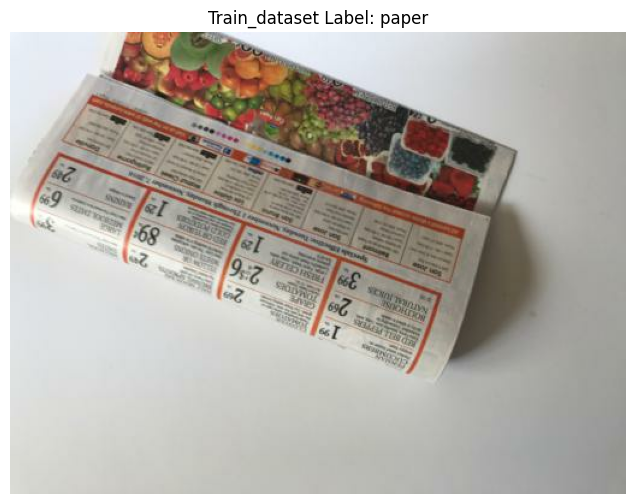




=========================== VALID_DATASET_DATA INFO ============================
image path: b'..\\artifacts\\data_ingestion\\dataset-resized\\cardboard\\cardboard132.jpg'
shape-image: (384, 512, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 247
min-intensity: 0
label: 0 -> cardboard
label-shape: ()
label-type: <dtype: 'int32'>



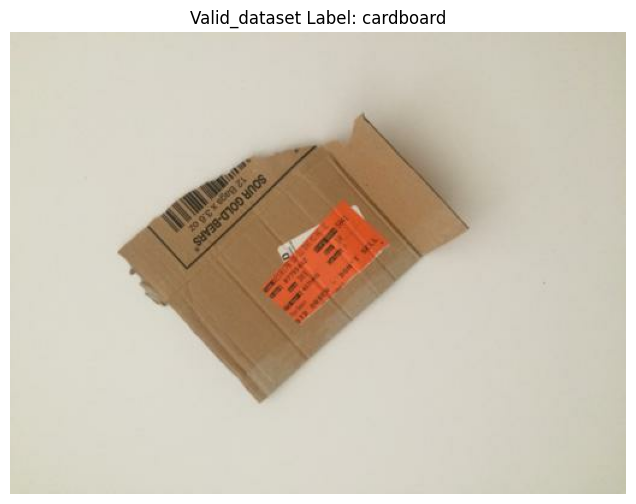

In [48]:
inspector.inspect(
    ispath=True,
    idx=1,
    train_dataset=train_tf_images,
    valid_dataset=valid_tf_images,
)

##### Check if the result of the image above with the label is appropriate based on the path

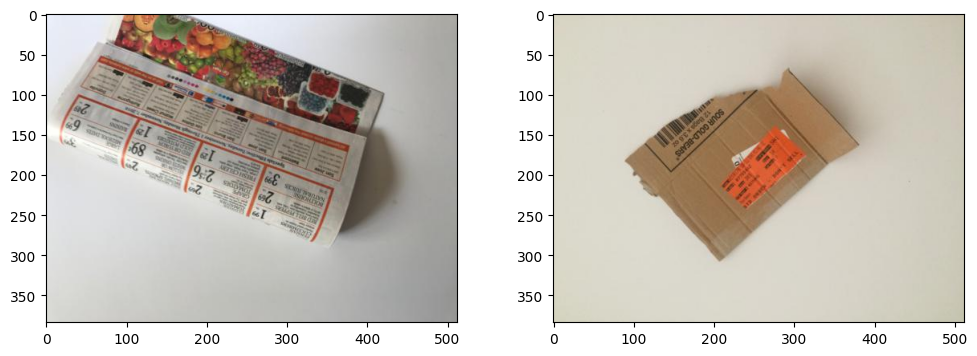

In [49]:
train_image = Image.open(f'{TRAIN_PATH}/paper/paper210.jpg')
valid_image = Image.open(f'{TRAIN_PATH}/cardboard/cardboard132.jpg')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(train_image)

plt.subplot(1, 2, 2)
plt.imshow(valid_image)

plt.show()

#### Image Resizing

In [50]:
train_tf_images_resized, valid_tf_images_resized = preprocessor.image_resizing(
    train_data=train_tf_images,
    valid_data=valid_tf_images,
)

In [51]:
show_data_info(
    train_dataset=train_tf_images_resized,
    valid_dataset=valid_tf_images_resized
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 255
min-intensity: 11
label: 1 -> glass
label-shape: ()
label-type: <dtype: 'int32'>



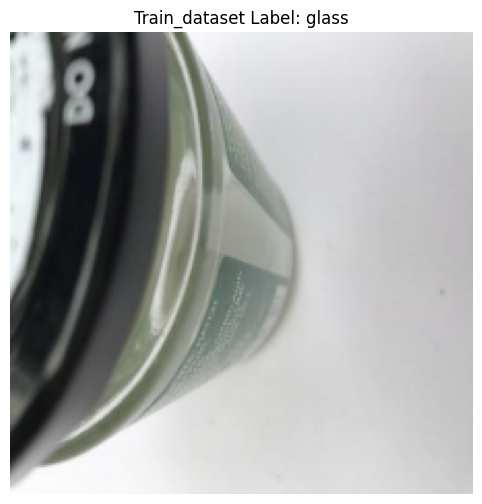




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 247
min-intensity: 0
label: 4 -> plastic
label-shape: ()
label-type: <dtype: 'int32'>



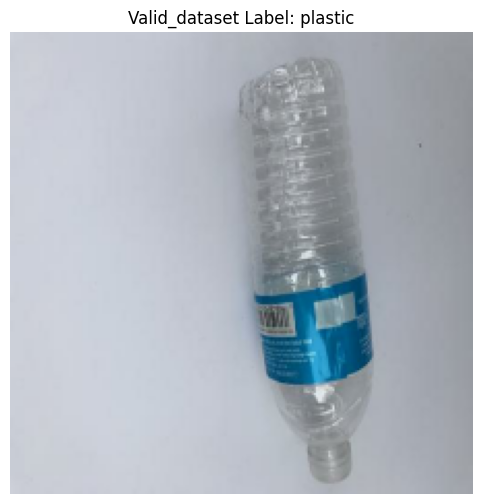

In [52]:
inspector.inspect(
    train_dataset=train_tf_images_resized,
    valid_dataset=valid_tf_images_resized
)

#### Image Normalization

In [53]:
train_tf_images_normalized, valid_tf_images_normalized = preprocessor.image_normalization(
    train_data=train_tf_images_resized,
    valid_data=valid_tf_images_resized,
)

In [54]:
show_data_info(
    train_dataset=train_tf_images_normalized,
    valid_dataset=valid_tf_images_normalized
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 1.0
min-intensity: 0.0313725508749485
label: 3 -> paper
label-shape: ()
label-type: <dtype: 'int32'>



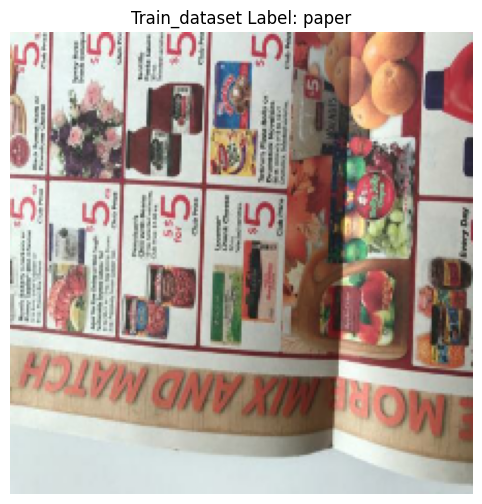




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 0.9764705896377563
min-intensity: 0.027450980618596077
label: 0 -> cardboard
label-shape: ()
label-type: <dtype: 'int32'>



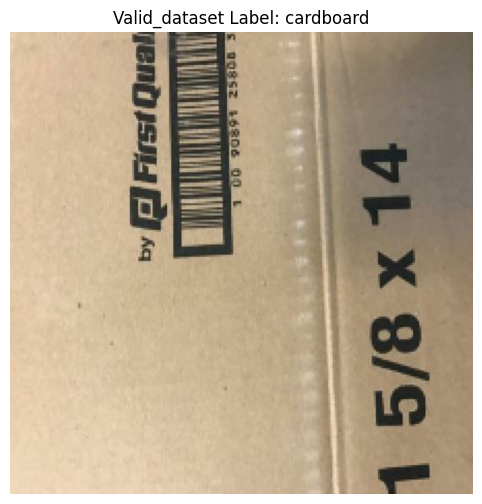

In [55]:
inspector.inspect(
    train_dataset=train_tf_images_normalized,
    valid_dataset=valid_tf_images_normalized
)

#### Image Augmentation

In [56]:
train_tf_images_augmented, valid_tf_images_augmented = preprocessor.image_augmentation(
    train_data=train_tf_images_normalized,
    valid_data=valid_tf_images_normalized
)

In [57]:
show_data_info(
    train_dataset=train_tf_images_augmented,
    valid_dataset=valid_tf_images_augmented
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 0.4956454038619995
min-intensity: 0.05808719992637634
label: 1 -> glass
label-shape: ()
label-type: <dtype: 'int32'>



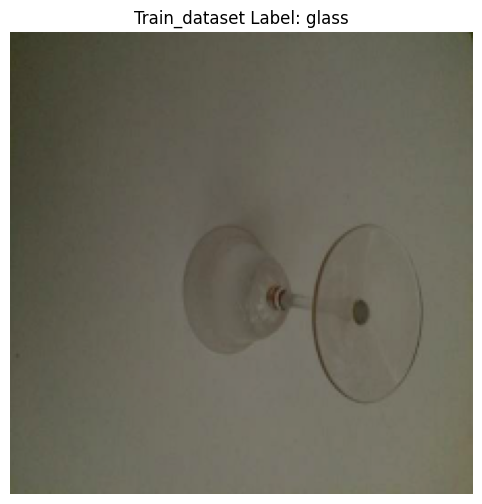




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 1.0
min-intensity: 0.20898695290088654
label: 1 -> glass
label-shape: ()
label-type: <dtype: 'int32'>



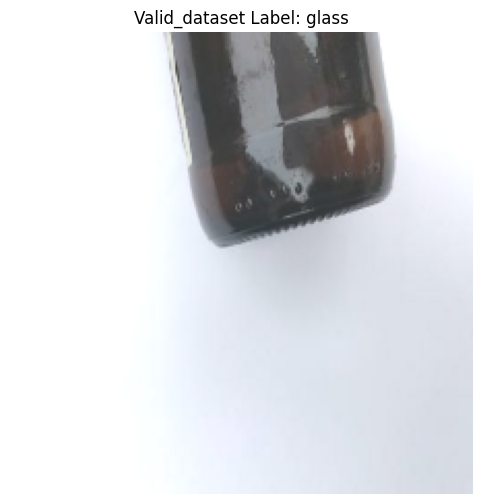

In [58]:
inspector.inspect(
    train_dataset=train_tf_images_augmented,
    valid_dataset=valid_tf_images_augmented
)

##### Whether data can be augmented using the preprocessor class

In [59]:
def convert_to_tensor(image):
    image = np.array(image)
    image = tf.cast(image / 255., tf.float32)
    return image

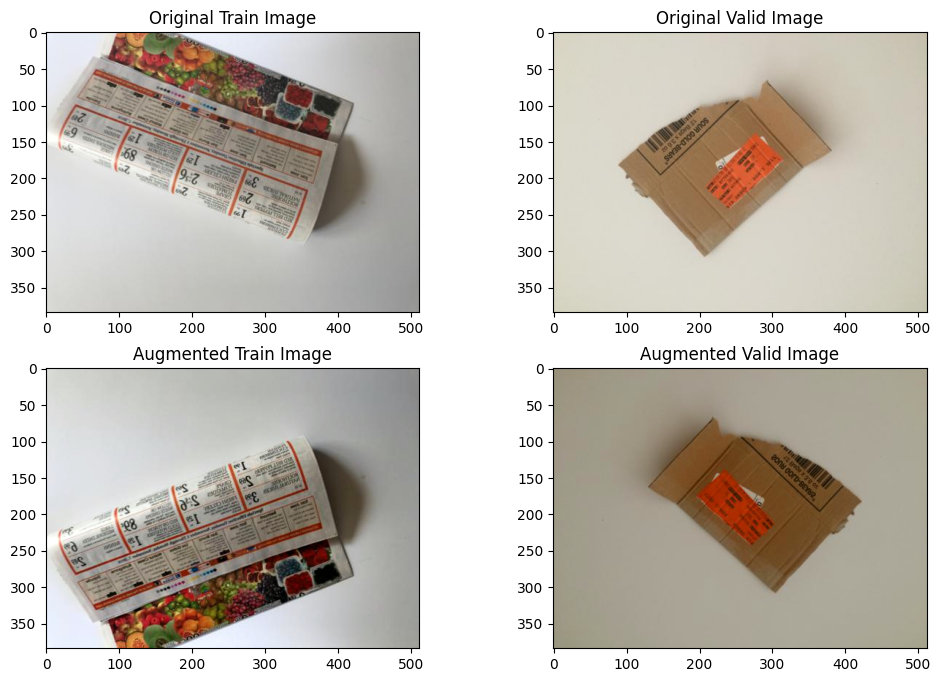

In [60]:
sample_train_image_tensor = convert_to_tensor(train_image)
sample_valid_image_tensor = convert_to_tensor(valid_image)

augmented_train_image, _ = preprocessor._augment_image(sample_train_image_tensor)
augmented_valid_image, _ = preprocessor._augment_image(sample_valid_image_tensor)


plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Original Train Image')
plt.imshow(train_image)

plt.subplot(2, 2, 2)
plt.title('Original Valid Image')
plt.imshow(valid_image)

plt.subplot(2, 2, 3)
plt.title('Augmented Train Image')
plt.imshow(augmented_train_image)

plt.subplot(2, 2, 4)
plt.title('Augmented Valid Image')
plt.imshow(augmented_valid_image)


plt.show()

## Step 4. Quality Check (Optional)

### function

In [61]:
def show_multiple_images_in_tf_data(dataset, n_skip, num_images, figsize_per_image=(3, 3), classes_list=None):
    """
    Display multiple images from the TensorFlow dataset in grid form.
    Args:
        dataset(tf.data.Dataset): A TensorFlow dataset containing images and labels.
        n_skip (int): The number of elements to skip before retrieving the image for display.
        num_images (int): The number of images to display.
        figsize_per_image (tuple, optional): The size of each image in the plot. Default is (3, 3).
        classes_list (list, optional): A list of class names used to title the image.
                                       Must be the same length as the number of classes in the dataset.
    Returns:
        None: This function only displays the image and returns no value.
    Notes:
        - If the dataset contains an (image, label) pair, the label will be used to title the image.
        - If the dataset contains only images, the title will not be displayed.
        - This function will ignore images that have more than two dimensions by subtracting additional dimensions if any.
        - The size of the entire grid is determined based on the number of images to be displayed, so it will be organized into rows and columns.
    """
    dataset = dataset.skip(n_skip).take(num_images)

    num_columns = math.ceil(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_columns)
    figsize = (num_columns * figsize_per_image[0], num_rows * figsize_per_image[1])

    plt.figure(figsize=figsize)

    for idx, data in enumerate(dataset):
        if len(data) == 2:
            image, label = data
        else:
            image = data
            label = None

        image = image.numpy()

        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)

        plt.subplot(num_rows, num_columns, idx + 1)
        plt.imshow(np.squeeze(image), cmap='gray')

        if label is not None:
            plt.title(classes_list[label])
        plt.axis('off')

    plt.show()


### main program

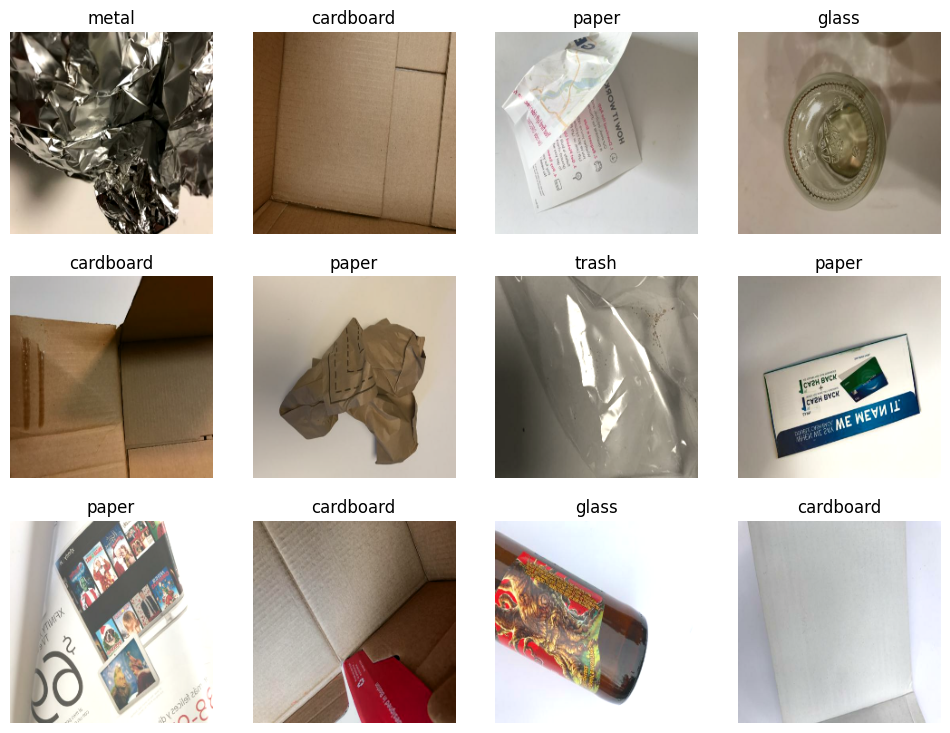

In [62]:
show_multiple_images_in_tf_data(
    train_tf_images_augmented,
    n_skip=1,
    num_images=12,
    classes_list=LABEL_LIST
)

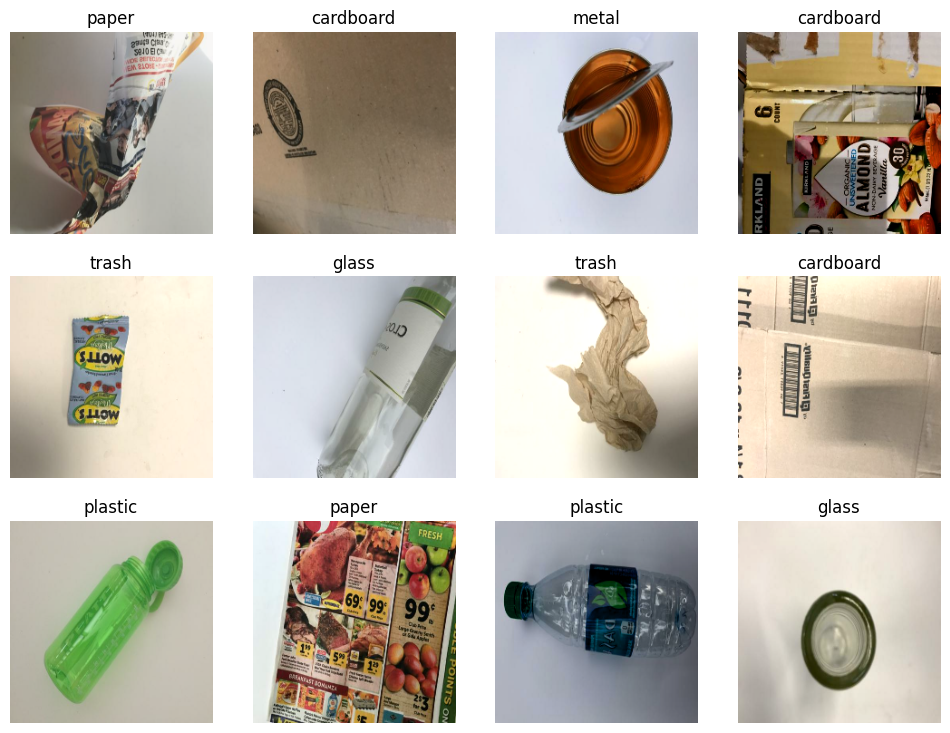

In [63]:
show_multiple_images_in_tf_data(
    valid_tf_images_augmented,
    n_skip=80,
    num_images=12,
    classes_list=LABEL_LIST
)

# SAVING DATA

This process may take a long time depending on the amount of data and the dimensions of the image or feature.

In [64]:
train_tf_images_augmented = train_tf_images_augmented.cache()
valid_tf_images_augmented = valid_tf_images_augmented.cache()

In [65]:
train_tf_images_augmented.save(TRAIN_TFRECOARD_PATH, compression="GZIP")
valid_tf_images_augmented.save(VALID_TFRECORD_PATH, compression="GZIP")